# Location assessment
*This notebook illustrates methods to assess the geography of a distribution network*  
*Use the virtual environment logproj_distribution.yml to run this notebook.*
***
Alessandro Tufano 2020

### Import packages

In [2]:
#suppress warnings
import warnings
warnings.filterwarnings("ignore")

# %% append functions path
import sys; sys.path.insert(0, '..') #add the above level with the package

#import utilities
from logproj.utilities import creaCartella

import numpy as np
import plotly
import plotly.express as px

from IPython.display import display, HTML

### Set data fields

In [3]:
#set project name
dbName='TOY_DATA'

In [4]:
#columns node data
latCol='LATITUDE'
lonCol='LONGITUDE'
colore='CLIENT_TYPE'
descrCol='NODECODE'
node_id= 'NODECODE'

In [5]:
#columns plant data
latCol_plant='LATITUDE'
lonCol_plant='LONGITUDE'
plantListName='listClient'
plant_id= 'NODECODE'

In [6]:
#columns movements data
movementColumns= {
           'timevariable':'TIMESTAMP_IN', #colonna obbligatoria con i timestamp per ogni movimento
           'capacityField':'QUANTITY', #colonna obblicatoria che identifica la quantita' movimentata
           
            'vehiclefield':'VEHICLE_CODE', #colonna che identifica il veicolo utilizzato
           
            'terminalfieldFrom':'LOADING_NODE', #colonna che identifica il nodo di carico
            'terminalfieldto':'DISCHARGING_NODE', #colonna che identifica il nodo di scarico
    
            'latitude_from': 'LOADING_NODE_LATITUDE', #latitude of the discharging node
            'longitude_from' : 'LOADING_NODE_LONGITUDE', #latitude of the discharging node
    
            'latitude_to' : 'DISCHARGING_LATITUDE', #latitude of the discharging node
            'longitude_to' : 'DISCHARGING_LONGITUDE' #latitude of the discharging node
    
    
    
    
  
           }

timeColumns = {'loadingpta':'PTA_FROM',
               'loadingptd':'PTD_FROM', 
               'dischargingpta':'PTA_TO', 
               'dischargingptd':'PTD_TO', 
               'loadingata':'ATA_FROM', 
               'loadingatd':'ATD_FROM', 
               'dischargingata':'ATA_TO', 
               'dischargingatd':'ATD_TO'
               }

### Set folder hierarchy

In [7]:
pathResults = 'C:\\Users\\aletu\\desktop'
_, root_path = creaCartella(pathResults,f"{dbName}_results")
_, path_results = creaCartella(root_path,f"P8_networkAssessment")
_, currentPath = creaCartella(path_results,f"Network Graph Assessment")

Cartella TOY_DATA_results già esistente
Cartella P8_networkAssessment già esistente
Cartella Network Graph Assessment già esistente


### Import data

In [8]:
# %% import data
from logproj.data_generator_distribution import generateDistributionData

#random generation of distribution data
D_table, _, D_plant, D_mov = generateDistributionData()
D_plant['_id'] =D_plant['NODECODE'] #set the id of the plant 

In [8]:
#print D_table (nodes)
display(HTML(D_table.to_html()))

In [9]:
#print D_plant
display(HTML(D_plant.to_html()))

In [10]:
#print D_mov
print(f"Table with {len(D_mov)} movements")
display(HTML(D_mov.to_html()))


Table with 100 movements


### Supply chain network nodetype

In [11]:
'''
D_table=D_table.dropna(subset=[latCol,lonCol])
D_table[colore]=D_table[colore].astype(str)

fig = px.scatter_mapbox(D_table, lat=latCol, lon=lonCol,
                     hover_name=descrCol, size="SIZE",color=colore)
fig.update_layout(mapbox_style="open-street-map")
plotly.offline.plot(fig, filename = f"{path_results}//supplyChainNodeType.html", auto_open=False)
fig.show()
'''

from logproj.P8_performanceAssessment.network_graph_analysis import supplyChainMap
fig, coverages = supplyChainMap(D_table=D_table,
                                latCol=latCol,
                                lonCol=lonCol,
                                descrCol=descrCol,
                                color=colore,
                                size='SIZE',
                                cleanOutliers=False)
plotly.offline.plot(fig, filename = f"{currentPath}//supplyChainNodeType.html", auto_open=False)
fig.show()
for key in coverages.keys():
    coverages[key].to_excel(currentPath+f"\\supplyChainNodeType_coverages.xlsx")


### Supply chain network nodes

In [12]:
'''
fig = px.scatter_mapbox(D_table, lat=latCol, lon=lonCol,
                     hover_name=descrCol, size="SIZE")
fig.update_layout(mapbox_style="open-street-map")
plotly.offline.plot(fig, filename = f"{path_results}//supplyChainNodes.html", auto_open=False)
fig.show()
'''
fig, coverages = supplyChainMap(D_table=D_table,
                                latCol=latCol,
                                lonCol=lonCol,
                                descrCol=descrCol,
                                color='SIZE',
                                size='SIZE',
                                cleanOutliers=False)
plotly.offline.plot(fig, filename = f"{currentPath}//supplyChainNodes.html", auto_open=False)
fig.show()
for key in coverages.keys():
    coverages[key].to_excel(currentPath+f"\\supplyChainNodes.xlsx")

### Supply chain covering

In [13]:
#the map use the same color for the nodes served by the same plant using the plant table

D_table['SERVICE_NODE']=np.nan


for index, row in D_table.iterrows():
    for plant in D_plant[plant_id]:
    
        if row[node_id] in D_plant[D_plant[plant_id]==plant][plantListName].iloc[0]:
            D_table['SERVICE_NODE'].loc[index]=plant
    
D_table['SERVICE_NODE']=D_table['SERVICE_NODE'].astype(str)    
fig = px.scatter_mapbox(D_table, lat=latCol_plant, lon=lonCol_plant,
                     hover_name=descrCol, size="SIZE",color='SERVICE_NODE')
fig.update_layout(mapbox_style="open-street-map")
plotly.offline.plot(fig, filename = f"{path_results}//supplyChainCovering.html", auto_open=False)   
fig.show()

In [14]:
#supply chain covering using the plant table
from logproj.P8_performanceAssessment.network_graph_analysis import supplyChainCovering
fig, output_coverages = supplyChainCovering(D_plant=D_plant,
                               D_mov=D_mov,
                               latCol_plant=latCol_plant,
                               lonCol_plant=lonCol_plant,
                               node_from=movementColumns['terminalfieldFrom'],
                               node_to=movementColumns['terminalfieldto'],
                               lonCol_to=movementColumns['longitude_to'],
                               latCol_to=movementColumns['latitude_to'],
                               capacityField=movementColumns['capacityField'],
                               cleanOutliers=False)

plotly.offline.plot(fig, filename = f"{currentPath}//supplyChainCovering.html", auto_open=False)
fig.show()
for key in output_coverages.keys():
    output_coverages[key].to_excel(currentPath+f"\\supplyChainCovering.xlsx")


### Supply chain centers of mass

In [15]:
D_plant['lon_ave'] = D_plant['lat_ave']=np.nan
for index, row in D_plant.iterrows():
    
    D_table_plant = D_table[D_table['SERVICE_NODE']==row[node_id]]
    lon_ave = np.nanmean(D_table_plant[lonCol_plant])
    lat_ave = np.nanmean(D_table_plant[latCol_plant])
    D_plant['lon_ave'].loc[index] = lon_ave
    D_plant['lat_ave'].loc[index] = lat_ave

#plot the existent plant
fig = px.scatter_mapbox(D_plant, lat=latCol_plant, lon=lonCol_plant, color=latCol_plant)

#plot the centers of mass
fig = fig.add_trace(px.scatter_mapbox(D_plant, lat='lat_ave', lon='lon_ave',color=plant_id).data[0])
fig.update_layout(mapbox_style="open-street-map")
plotly.offline.plot(fig, filename = f"{path_results}//supplyChainCentersOfMass.html", auto_open=False)   
fig.show()


In [16]:
#interactive centers of mass plot using plant table
import plotly.graph_objects as go
fig = go.Figure(go.Scattermapbox(
        lat=D_plant[latCol_plant],
        lon=D_plant[lonCol_plant],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color = 'blue'
        ),
        text='ASIS',
        name='Plant AS IS Location'
    ))

fig.add_trace(
        go.Scattermapbox(
        lat=D_plant['lat_ave'],
        lon=D_plant['lon_ave'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color = 'red',
            #symbol = 'cross'
        ),
        text="CENTER OF MASS",
        name='Plant Center of Mass'
        )
    )

fig.add_trace(px.scatter_mapbox(D_table, lat=latCol, lon=lonCol,
                     hover_name=descrCol, color='SERVICE_NODE').data[0])
fig.update_layout(mapbox_style="open-street-map")
fig.show()
plotly.offline.plot(fig, filename = f"{path_results}//supplyChainCentersOfMass.html", auto_open=False)  

'C:\\Users\\aletu\\desktop\\TOY_DATA_results\\P8_networkAssessment//supplyChainCentersOfMass.html'

In [17]:
#interactive centers of mass plot using movement table
from logproj.P8_performanceAssessment.network_graph_analysis import supplyChainCentersOfMass
fig, output_coverages = supplyChainCentersOfMass(D_plant=D_plant,
                               D_mov=D_mov,
                               latCol_plant=latCol_plant,
                               lonCol_plant=lonCol_plant,
                               node_from=movementColumns['terminalfieldFrom'],
                               node_to=movementColumns['terminalfieldto'],
                               lonCol_to=movementColumns['longitude_to'],
                               latCol_to=movementColumns['latitude_to'],
                               capacityField=movementColumns['capacityField'],
                               cleanOutliers=False)
plotly.offline.plot(fig, filename = f"{currentPath}//supplyChainCentersOfMass.html", auto_open=False)    
fig.show()
for key in output_coverages.keys():
    output_coverages[key].to_excel(currentPath+f"\\supplyChainCentersOfMass.xlsx")

### Import road graph

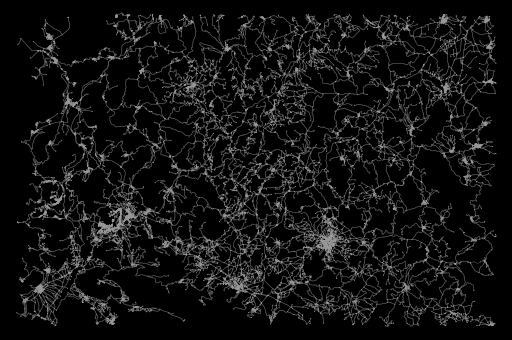

In [18]:
#Import graph package
import osmnx as ox
from logproj.P6_placementProblem.distribution_graph_definition import import_graph_drive

G, _ = import_graph_drive(D_table,latCol,lonCol,D_plant, latCol_plant, lonCol_plant,cleanOutliers=False)

# rappresento il grafo
fig, ax = ox.plot_graph(G, bgcolor='k', 
                        node_size=1, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

#salvo figura del grafo
fig.savefig(f"{path_results}//road_network.png")


### Analyse network rays

In [19]:
from logproj.P8_performanceAssessment.network_graph_analysis import networkRaysPlot

outputfigures, outputCoverages = networkRaysPlot(D_mov=D_mov, 
                                timecol=movementColumns['timevariable'],
                                lonCol_to=movementColumns['longitude_to'], 
                                latCol_to=movementColumns['latitude_to'], 
                                lonCol_from=movementColumns['longitude_from'], 
                                latCol_from=movementColumns['latitude_from'], 
                                G=G,
                                capacityField=movementColumns['capacityField'],
                                sampleInterval='year')

for key in outputfigures.keys():
        outputfigures[key].savefig(currentPath+f"\\{key}.png")
        outputfigures[key]
for key in outputCoverages.keys():
        outputCoverages[key].to_excel(currentPath+f"\\{key}.xlsx")
#check the output folder to see the resulting figure

### Analyse network arcs

**** DEFINISCO D MOV IN/OUT ****
**** DEFINISCO ROUTE  ****
**** RICOSTRUZIONE DEGLI INVENTARI  ****
==RICOSTRUISCO INVENTARIO VIAGGIO TRUCK 1, con 189 MOVIMENTI


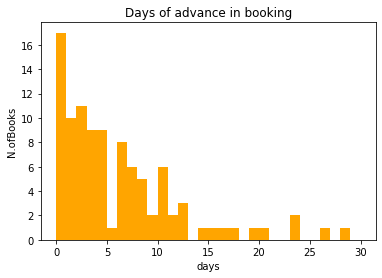

In [20]:
# generate arc flow data using theV EHICLE STATISTICS
from logproj.P8_performanceAssessment.vehicle_assessment import D_voyageStatistics
         
        
#define arc table
D_route,  D_arcs_route, D_coverages  = D_voyageStatistics(D_mov,
                                    timefield=movementColumns['timevariable'],
                                    locfrom = movementColumns['terminalfieldFrom'],
                                    locto= movementColumns['terminalfieldto'],
                                    timeColumns = timeColumns,
                                    capacityField=movementColumns['capacityField'],
                                    voyagefield =movementColumns['vehiclefield'],
                                    censoredData=False, #use complete data   
                                    actual='ACTUAL') #use actual data           

In [21]:
#print arc flow table
display(HTML(D_arcs_route.to_html()))           

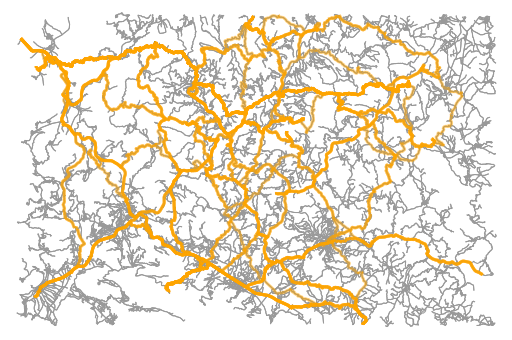

In [22]:
#plot travelled arcs on the graph
from logproj.P8_performanceAssessment.network_graph_analysis import networkRoadsRoutePlot
if len(D_arcs_route)>0:
    outputfigures = networkRoadsRoutePlot(D_arcs=D_arcs_route,
                                          lonCol_from = 'DISCHARGING_LONGITUDE_from', 
                                          latCol_from ='DISCHARGING_LATITUDE_from', 
                                          latCol_to ='DISCHARGING_LATITUDE_to',
                                          lonCol_to = 'DISCHARGING_LONGITUDE_to', 
                                          G=G)
    for key in outputfigures.keys():
            outputfigures[key].savefig(currentPath+f"\\{key}.png")

### Direct geocoding (from coortinates to address)

In [21]:
#remember to set your api keys in this package
from logproj.P6_placementProblem.distribution_geocoder import directGeocoder

#create columns to feed
D_table['ADDRESS_api'] = 'Not found'
D_table['CITY_api'] = 'Not found'
D_table['ZIPCODE_api'] = 'Not found'

D_table = D_table.reset_index(drop=True)
for index, row in D_table.iterrows():
    dict_geo = row[['LATITUDE','LONGITUDE']].to_dict()
    geoData = directGeocoder(dict_geo)
    #print(index)
    if 'ADDRESS_api' in geoData.keys():
        D_table.at[index,'ADDRESS_api'] = str(geoData['ADDRESS_api'])
    if 'CITY_api' in geoData.keys():
        D_table.at[index,'CITY_api'] = str(geoData['CITY_api'])
    if 'ZIPCODE_api' in geoData.keys():
        D_table.at[index,'ZIPCODE_api'] = str(geoData['ZIPCODE_api'])

#print updated table
display(HTML(D_table.to_html()))    

**GEOCODER: geodata found at {'LATITUDE_api': 41.773860931396484, 'LONGITUDE_api': 14.259949684143066, 'ADDRESS_api': 'Vastogirardi, Molise, Italy', 'CITY_api': 'Vastogirardi', 'COUNTRY_api': 'Italy', 'STATE_api': 'Molise'}
**GEOCODER: geodata found at {'LATITUDE_api': 41.85658, 'LONGITUDE_api': 14.23361, 'ADDRESS_api': 'Via Borgo Saletta 22, 86080 Castel del Giudice Isernia', 'CITY_api': 'Castel del Giudice', 'COUNTRY_api': 'Italy', 'STATE_api': 'Molise', 'ZIPCODE_api': '86080'}
**GEOCODER: geodata found at {'LATITUDE_api': 41.4290414, 'LONGITUDE_api': 14.7257612, 'ADDRESS_api': 'Strada Comunale Aria di Muzio, 86012 Cercemaggiore Campobasso', 'CITY_api': 'Cercemaggiore', 'COUNTRY_api': 'Italy', 'STATE_api': 'Molise', 'ZIPCODE_api': '86012'}
**GEOCODER: geodata found at {'LATITUDE_api': 41.4520752, 'LONGITUDE_api': 14.7698084, 'ADDRESS_api': 'Strada Provinciale Riccia Cercemaggiore, 86012 Cercemaggiore Campobasso', 'CITY_api': 'Cercemaggiore', 'COUNTRY_api': 'Italy', 'STATE_api': 'Moli

### Reverse geocoding (from address to coordinates)

In [28]:
#remember to set your api keys in this package
from logproj.P6_placementProblem.distribution_geocoder import addressGeocoder

#create columns to feed
D_table['LATITUDE_api'] = np.nan
D_table['LONGITUDE_api'] = np.nan

D_table = D_table.reset_index(drop=True)
for index, row in D_table.iterrows():
    
    dict_address = {#'ADDRESS' : row['ADDRESS_api'],
                    'CITY' : row['CITY_api'],
                    'ZIPCODE' : row['ZIPCODE_api'],
                   }
    #print(dict_address)
    geoData = addressGeocoder(dict_address)
    if isinstance(geoData, dict):
        if 'LATITUDE_api' in geoData.keys():
            D_table.at[index,'LATITUDE_api'] = float(geoData['LATITUDE_api'])
        if 'LONGITUDE_api' in geoData.keys():
            D_table.at[index,'LONGITUDE_api'] = float(geoData['LONGITUDE_api'])


#print updated table
display(HTML(D_table.to_html()))    

**GEOCODER: geodata found at {'LATITUDE_api': 41.773860931396484, 'LONGITUDE_api': 14.259949684143066, 'ADDRESS_api': 'Vastogirardi, Mol., Italy', 'CITY_api': 'Vastogirardi', 'COUNTRY_api': 'Italy', 'STATE_api': 'Mol.'}
**GEOCODER: geodata found at {'LATITUDE_api': 41.85435104370117, 'LONGITUDE_api': 14.22776985168457, 'ADDRESS_api': 'Castel del Giudice, Mol., Italy', 'CITY_api': 'Castel del Giudice', 'COUNTRY_api': 'Italy', 'STATE_api': 'Mol.'}
**GEOCODER: geodata found at {'LATITUDE_api': 41.459110260009766, 'LONGITUDE_api': 14.719539642333984, 'ADDRESS_api': 'Cercemaggiore, Mol., Italy', 'CITY_api': 'Cercemaggiore', 'COUNTRY_api': 'Italy', 'STATE_api': 'Mol.'}
**GEOCODER: geodata found at {'LATITUDE_api': 41.459110260009766, 'LONGITUDE_api': 14.719539642333984, 'ADDRESS_api': 'Cercemaggiore, Mol., Italy', 'CITY_api': 'Cercemaggiore', 'COUNTRY_api': 'Italy', 'STATE_api': 'Mol.'}
**GEOCODER: geodata found at {'LATITUDE_api': 41.9217414855957, 'LONGITUDE_api': 14.234919548034668, 'ADDR